In [1]:
%load_ext autoreload
%autoreload 2
import datajoint as dj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pipeline.ingest import behavior as behavior_ingest
from pipeline.ingest import ephys as ephys_ingest
from pipeline import lab, get_schema_name, experiment, foraging_analysis, report, ephys, histology, psth_foraging, ccf
import pipeline.shell as shell
from pipeline import psth_foraging
from pipeline.plot import unit_psth

shell.logsetup('INFO')
[hh for hh in dj.list_schemas() if 'hanhou' in hh]

Connecting hanhou@datajoint.mesoscale-activity-map.org:3306


['hanhou_foraging_ccf',
 'hanhou_foraging_ephys',
 'hanhou_foraging_experiment',
 'hanhou_foraging_foraging_analysis',
 'hanhou_foraging_foraging_model',
 'hanhou_foraging_histology',
 'hanhou_foraging_ingest_behavior',
 'hanhou_foraging_ingest_ephys',
 'hanhou_foraging_ingest_histology',
 'hanhou_foraging_lab',
 'hanhou_foraging_psth',
 'hanhou_foraging_psth_foraging',
 'hanhou_foraging_publication',
 'hanhou_foraging_report',
 'hanhou_foraging_tracking',
 'hanhou_test_schema']

# Basic structure of the public DB

The purpose here is to navigate through the tables for MAP phase 1 and see what I should prepare for the foraging task. <br>
To access the tables in the public DB, I have to find the correct schema and spawn the missing classes, like this.

In [ ]:
[public for public in dj.list_schemas() if 'map_v2' in public]

In [ ]:
public_lab = dj.schema('map_v2_lab'); public_lab.spawn_missing_classes()
public_ingest_ephys = dj.schema('map_v2_ingest_ephys'); public_ingest_ephys.spawn_missing_classes()
public_ephys =  dj.schema('map_v2_ephys'); public_ephys.spawn_missing_classes()

After doing this, query the public tables by directly calling the names `EphysIngest` or `WaterRestriction` instead of `ephys.EphysIngest` or `lab.WaterRestriction` (which are my private tables) <br>
Compare the two below:

In [ ]:
dj.ERD(public_lab)

In [ ]:
dj.ERD(lab)

In [ ]:
dj.ERD(public_ephys)

Let's see what's in the public `EphysIngest`

In [ ]:
EphysIngest() * EphysIngest.EphysFile() * WaterRestriction() & 'water_restriction_number = "SC050"'

In [ ]:
ProbeInsertion.InsertionNote()

In [ ]:
BrainArea()

In [ ]:
ProbeInsertion.RecordableBrainRegion()

In [ ]:
BrainAreaDepthCriteria()

In [ ]:
ProbeInsertionQuality()

# What do I have now?

In [ ]:
dj.ERD(ephys)

All probe insertions

In [ ]:
(ephys.ProbeInsertion() * experiment.Session()).fetch()

In [ ]:
ephys.ProbeInsertion().RecordableBrainRegion()

Sessions that have ephys

In [ ]:
experiment.Session & ephys.ProbeInsertion()

The number of ks2 units for each probe

In [ ]:
ephys.ProbeInsertion.aggr(ephys.Unit.proj(electrode_config_name_Unit='electrode_config_name'), n='count(*)')

In [ ]:
ephys.Unit()

In [ ]:
ephys.UnitStat()

# Add bitcode to my own pipeline

Check bitcode on public DB

In [ ]:
public_experiment = dj.schema('map_v2_experiment')
public_experiment.spawn_missing_classes()
dj.ERD(public_experiment)

In [ ]:
((TrialNote() & 'trial_note_type = "bitcode"') * WaterRestriction.proj('water_restriction_number') & 'water_restriction_number = "SC050" OR water_restriction_number = "DL011"') & 'session = 1' & 'trial = 1'

So obviously them have increased the length of bitcode from 10 to 20 at some point.

Now let me check whether my bitcodes have been correctly ingested. (note the module name `experiment` and `lab` here)

In [ ]:
(experiment.TrialNote() & 'trial_note_type = "bitcode"') * lab.WaterRestriction.proj('water_restriction_number') & 'trial = 1'

It makes sense that the session numbers don't start from 1 because I just introduced bitcode into my pybpod code recently.

In [ ]:
foraging_sessions = (experiment.Session & "username='HH'")  * lab.WaterRestriction().proj('water_restriction_number') & (experiment.BehaviorTrial & 'task in ("foraging")')
foraging_sessions

List all foraging sessions that have bitcode and also show some stats

In [ ]:
(experiment.Session * foraging_analysis.SessionStats.proj('session_total_trial_num', 'session_foraging_eff_optimal') 
 * lab.WaterRestriction().proj('water_restriction_number') & (experiment.TrialNote() & 'trial_note_type = "bitcode"')
).fetch(format='frame') 

# Ephys Ingestion

In [ ]:
dj.ERD(ephys) + dj.ERD(ephys_ingest)

## Prepare the electrodes!!!

In [ ]:
lab.ProbeType()

In [ ]:
for probe_type in lab.ProbeType.fetch():
    print(probe_type[0])
    lab.ProbeType.create_neuropixels_probe(probe_type=probe_type[0])

In [ ]:
lab.ProbeType.Electrode()

## Find the sessions that have ephys data ingested

In [ ]:
experiment.Session() * lab.WaterRestriction.proj('water_restriction_number') & ephys.ProbeInsertion() 

In [ ]:
from pipeline.ingest import ephys as ephys_ingest
ephys_ingest.EphysIngest.EphysFile & lab.WaterRestriction.proj('water_restriction_number') & ephys.ProbeInsertion() 

In [ ]:
ephys.ProbeInsertion() * experiment.Session() * lab.WaterRestriction.proj('water_restriction_number') 

To delete certain insertions

In [ ]:
ephys.ProbeInsertion().delete()

Should also delete ephys_ingest.EphysIngest() table!!

In [ ]:
ephys_ingest.EphysIngest().delete()

## Ingest ephys sessions

Ingest ephys

In [ ]:
shell.ingest_ephys()

Ingest ephys notes

In [ ]:
shell.load_insertion_location(dj.config.get('custom').get('recording_notes_spreadsheet'))

Check all meta data for `ephys.ProbeInsertion`

In [ ]:
ephys.ProbeInsertion * ephys.ProbeInsertion.InsertionLocation * ephys.ProbeInsertion.RecordableBrainRegion * ephys.ProbeInsertion.RecordingSystemSetup

Compute UnitStat (see `shell.populate_ephys`)

In [ ]:
populate_settings={'reserve_jobs': True, 'display_progress': True}
ephys.UnitStat.populate(**populate_settings)

Compute UnitCellType (see `shell.populate_ephys`)

In [ ]:
ephys.UnitCellType.populate(**populate_settings)

# QC

The one Dave showed (a little strigent for me now)

In [8]:
len((ephys.Unit * ephys.ClusterMetric * ephys.UnitStat * ephys.MAPClusterMetric.DriftMetric) & 'presence_ratio > 0.95' & 'amplitude_cutoff < 0.1' & 'isi_violation < 0.5' & 'unit_amp > 70' & 'drift_metric < 0.1')

543

# Histology ingestion

## Preparation

In [2]:
from pipeline import ccf

In [ ]:
ccf.CCFBrainRegion.load_regions()
ccf.AnnotatedBrainSurface.load_matlab_mesh('Annotation_new_10_ds222_16bit_isosurf.mat')

In [ ]:
ccf.CCFAnnotation.load_ccf_annotation()

Total length in the main pipeline = 63265854

In [4]:
len(ccf.CCFAnnotation())

63265854

Finally done!!

## CCFAnnotation

Check histology

In [8]:
(experiment.Session & histology.ElectrodeCCFPosition) * (lab.WaterRestriction.proj('water_restriction_number'))

subject_id institution 6 digit animal ID,session session number,session_date,session_time,username,rig,water_restriction_number WR number
473361,46,2021-04-16,0:01:12,HH,Ephys-Han,HH09
473361,47,2021-04-18,23:00:03,HH,Ephys-Han,HH09
473361,48,2021-04-19,21:53:49,HH,Ephys-Han,HH09
473361,50,2021-04-29,17:58:45,HH,Ephys-Han,HH09
473361,57,2021-06-09,16:28:15,HH,Ephys-Han,HH09
473361,58,2021-06-11,15:32:12,HH,Ephys-Han,HH09
473361,59,2021-06-12,14:18:29,HH,Ephys-Han,HH09
473361,60,2021-06-13,20:27:10,HH,Ephys-Han,HH09
473361,61,2021-06-14,20:07:51,HH,Ephys-Han,HH09


Do ingestion

In [ ]:
shell.ingest_histology()

Check all of the brains assigned to me (sessions that have histology)

In [9]:
my_assigned_brains = 'water_restriction_number in ("HH09")'
my_registered_sessions = experiment.Session * lab.WaterRestriction.proj('water_restriction_number') & histology.ElectrodeCCFPosition & my_assigned_brains

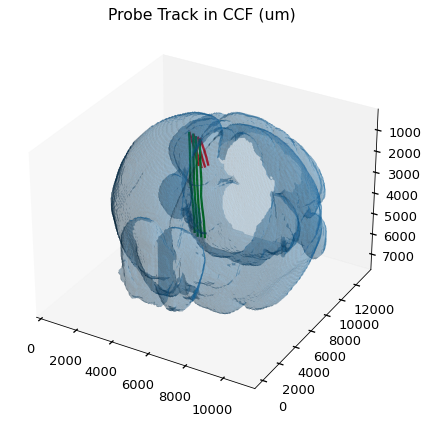

In [11]:
from pipeline.plot import histology_plot
histology_plot.plot_probe_tracks(my_registered_sessions);

Check insertions that do **NOT** have histology

In [12]:
my_assigned_brains = lab.WaterRestriction.proj('water_restriction_number') & 'water_restriction_number in ("HH09")'
my_assigned_insertions = ephys.ProbeInsertion * experiment.Session  * my_assigned_brains
print(f'All insertions assigned to me: {len(my_assigned_insertions)}')
my_assigned_insertions - histology.ElectrodeCCFPosition

All insertions assigned to me: 18


subject_id institution 6 digit animal ID,session session number,insertion_number,probe unique identifier for this model of probe (e.g. part number),probe_type e.g. neuropixels_1.0,electrode_config_name user friendly name,session_date,session_time,username,rig,water_restriction_number WR number
473361,42,1,17131309211,neuropixels 1.0 - 3B,1-384,2021-04-06,4:49:48,HH,Ephys-Han,HH09
473361,46,2,18005123491,neuropixels 1.0 - 3B,1-384,2021-04-16,0:01:12,HH,Ephys-Han,HH09


Show all recorded areas

In [3]:
dj.U('annotation').aggr((ephys.Unit * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation, count='count(*)').fetch(format='frame', order_by='count desc')[:30]

,count
annotation,
"Secondary motor area, layer 6a",723
Anterior olfactory nucleus,564
Mediodorsal nucleus of thalamus,464
"Secondary motor area, layer 5",422
"Orbital area, medial part, layer 5",417
"Prelimbic area, layer 5",396
Caudoputamen,391
"Orbital area, ventrolateral part, layer 5",259
Posterior complex of the thalamus,238


After stringent QC

In [9]:
qc = (ephys.Unit * ephys.ClusterMetric * ephys.UnitStat * ephys.MAPClusterMetric.DriftMetric) & 'presence_ratio > 0.95' & 'amplitude_cutoff < 0.1' & 'isi_violation < 0.5' & 'unit_amp > 70' & 'drift_metric < 0.1'
dj.U('annotation').aggr(((ephys.Unit & qc.proj()) * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation, count='count(*)').fetch(format='frame', order_by='count desc')[:30]

,count
annotation,
"Secondary motor area, layer 6a",47
Anterior olfactory nucleus,36
Mediodorsal nucleus of thalamus,33
"Secondary motor area, layer 5",28
Dorsal peduncular area,24
Caudoputamen,22
"Orbital area, ventrolateral part, layer 5",21
"Orbital area, ventrolateral part, layer 2/3",19
"Retrosplenial area, ventral part, layer 5",18


# Trial Number issue

Retrieve the original bpod files for a certain session.

In [ ]:
from pipeline.ingest.behavior import BehaviorBpodIngest
BehaviorBpodIngest.BehaviorFile() * experiment.Session() * lab.WaterRestriction.proj('water_restriction_number') & 'session_date = "2021-04-18"'

The potential bug of having the same bitcode because of the fixed rand seed.

In [ ]:
experiment.TrialNote & 'trial_note = "01000110111010000110"'

In [ ]:
dj.ERD(ephys)

# Timing issue

In [ ]:
from pipeline.ingest.util import compare_ni_and_bpod_times

In [ ]:
compare_ni_and_bpod_times()

# Code cache

In [ ]:
experiment.Session & 'session = 35' & 'subject_id = 473361'

In [ ]:
experiment.TrialEvent()


In [ ]:
behavior_ingest.BehaviorBpodIngest.BehaviorFile.key_source()

Histology ingest

In [ ]:
(histology.ElectrodeCCFPosition * experiment.Session) & \
(lab.WaterRestriction  & 'water_restriction_number = "SC045"')

In [ ]:
(histology.ElectrodeCCFPosition * experiment.Session) & \
(lab.WaterRestriction  & 'water_restriction_number = "SC050"')